In [ ]:
import pandas as pd
import numpy as np

In [ ]:
file_data = pd.read_csv("data.csv",encoding='latin1')
file_data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,6,7,9,10,11,12,13,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME,Unnamed: 5,MAGNITUDE,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,LAT (N),LONG (E),DEPTH (km),INTENSITY,Unnamed: 16,Unnamed: 17,LOCATION,REFERENCE
0,NaN,NaN,NaN,NaN,(UTC),(IST),Mw,Mw,Mb,Mb,Ms,ML,NaN,NaN,NaN,MM,MMI,MME,NaN,NaN
1,1.0,-2474.0,0,0.0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0.0,NaN,NaN,NaN,NaN,Dr STGR
2,2.0,-325.0,0,0.0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0.0,NaN,NaN,NaN,NaN,Dr STGR
3,3.0,25.0,0,0.0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,72.9,33.72,0.0,NaN,NaN,NaN,NaN,Dr STGR
4,4.0,26.0,5,10.0,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,5.698851894,5.999685205,17.3,80.1,NaN,NaN,NaN,NaN,NaN,NEIC


In [ ]:
# drop row 0
file_data = file_data.drop(file_data.index[0])
file_data.head()

,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME,Unnamed: 5,MAGNITUDE,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,LAT (N),LONG (E),DEPTH (km),INTENSITY,Unnamed: 16,Unnamed: 17,LOCATION,REFERENCE
1,1.0,-2474.0,0,0.0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0.0,NaN,NaN,NaN,NaN,Dr STGR
2,2.0,-325.0,0,0.0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0.0,NaN,NaN,NaN,NaN,Dr STGR
3,3.0,25.0,0,0.0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,72.9,33.72,0.0,NaN,NaN,NaN,NaN,Dr STGR
4,4.0,26.0,5,10.0,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,5.698851894,5.999685205,17.3,80.1,NaN,NaN,NaN,NaN,NaN,NEIC
5,5.0,26.0,5,10.0,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,6.075520196,5.999685205,26,97,80.0,NaN,NaN,NaN,Myanmar,G-R


In [ ]:
# shuffle rows
# file_data = file_data.sample(frac = 1) 
# file_data.tail()

In [ ]:
import re
def edit_latitude(val):
  if type(val) == str:
    new_val = val.replace('?','').replace(' ','').replace(',','.')
    new_val = re.sub('[^a-zA-Z0-9\.]', '', new_val)
    if new_val[-1] == 'N':
        new_val = float(new_val[0:-1])
    elif new_val[-1] == 'S':
        new_val = 180 -1*float(new_val[0:-1])
    elif new_val[-1] == 'E':
        new_val = float(new_val[0:-1])    
    else:
      new_val = float(new_val)  
    return new_val
  return float(val)

In [ ]:
import re
def edit_longitude(val):
  if type(val) == str:
    new_val = val.replace('?','').replace(' ','').replace(',','.')
    new_val = re.sub('[^a-zA-Z0-9\.]', '', new_val)
    if new_val[-1] == 'E':
        new_val = float(new_val[0:-1])
    elif new_val[-1] == 'W':
        new_val = 360 - 1*float(new_val[0:-1])
    elif new_val[-1] == 'S':
        new_val = float(new_val[0:-1])
    else:
      new_val = float(new_val)  
    return new_val
  return float(val)

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
# file_data.columns
# filter data
req_features = ['LAT (N)','LONG (E)','DEPTH (km)','MAGNITUDE']
filtered_data = file_data[req_features]
print(filtered_data.shape)
filtered_data['LAT (N)'] = filtered_data['LAT (N)'].apply(edit_latitude)
filtered_data['LONG (E)'] = filtered_data['LONG (E)'].apply(edit_longitude)
filtered_data = clean_dataset(filtered_data)
print(filtered_data.shape)

(52989, 4)
(40107, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [ ]:
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()

x_features = ['LAT (N)','LONG (E)','DEPTH (km)']
X = filtered_data[x_features]
y = filtered_data['MAGNITUDE']
# X = lab_enc.fit_transform(X)
y = lab_enc.fit_transform(y)
print(X.shape)
print(y.shape)

(40107, 3)
(40107,)


In [ ]:
threshold = 4.20
y = y.astype('float')
y_m = y.copy()
y_m[y_m < threshold] = 0
y_m[y_m >= threshold] = 1
y = y_m.copy()
print(y)

# test-train split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3,random_state=1)
train_X.describe()
print(np.any(np.isnan(train_y)))

[1. 1. 1. ... 1. 1. 1.]
False


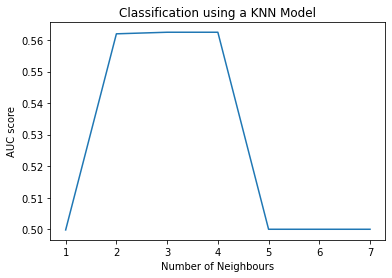

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier as KNNmodel
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

plot_x = []
plot_y = []

for K in range(1, 8):
    knn = KNNmodel(n_neighbors=K)
    knn.fit(train_X, train_y)
    y_pred = knn.predict(test_X)
    plot_x.append(K)
    plot_y.append(roc_auc_score(test_y, y_pred))

plt.plot(plot_x, plot_y)
plt.title('Classification using a KNN Model')
plt.xlabel('Number of Neighbours')
plt.ylabel('AUC score')
plt.show()

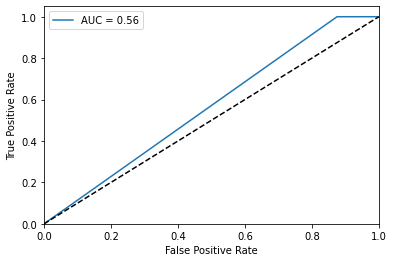

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

knn = KNNmodel(n_neighbors=4)
knn.fit(train_X, train_y)
y_pred = knn.predict(test_X)
fpr, tpr, _ = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='upper left')
plt.show()

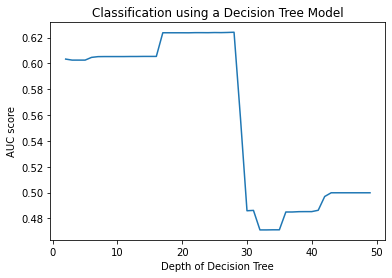

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

plot_x = []
plot_y = []

for nodes in range(2, 50):
    model = DecisionTreeRegressor(max_leaf_nodes=nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(test_X)
    plot_x.append(nodes)
    plot_y.append(roc_auc_score(test_y, preds_val))

plt.plot(plot_x, plot_y)
plt.xlabel('Depth of Decision Tree')
plt.ylabel('AUC score')
plt.title('Classification using a Decision Tree Model')
plt.show()

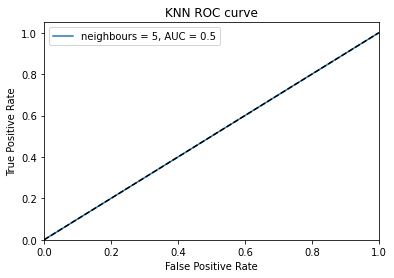

In [ ]:
for node in [5]:
  model = KNNmodel(n_neighbors=node)
  model.fit(train_X, train_y)
  y_pred = model.predict(test_X)
  fpr, tpr, _ = roc_curve(test_y, y_pred)
  roc_auc = auc(fpr, tpr)
# plt.figure()
  labelstr = "neighbours = " + str(node) + ", AUC = " + str(roc_auc)
  plt.plot(fpr, tpr, label = labelstr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='upper left')
plt.title('KNN ROC curve')
plt.show()